In [2]:
import torch
import torch.nn as nn
from torch import optim

import numpy as np
import matplotlib.pyplot as plt

from BayesianNeuralNetwork import BayesianNN

In [3]:
## helper function for plotting

def plot_predictions(model,title):
    x_test = torch.arange(start=-0.5,end=1.5,step=0.001)
    x_test = torch.unsqueeze(x_test,dim=1)

    y_pred_list = []

    for i in range(50):
        y_pred = model(x_test).detach().numpy()
        y_pred_list.append(y_pred)


    y_preds = np.concatenate(y_pred_list, axis=1)

    y_mean = np.mean(y_preds, axis=1)
    y_sigma = np.std(y_preds, axis=1)

    plt.figure(figsize=(5,5))
    plt.plot(x_test, y_mean, 'r-', label='predictive mean')
    plt.scatter(x, y, marker='+', label='training data')
    plt.fill_between(x_test.numpy().ravel(), 
                    y_mean + 2 * y_sigma, 
                    y_mean - 2 * y_sigma, 
                    alpha=0.5, label='epistemic uncertainty')
    plt.title(title)
    plt.legend()

classical NN, weights are deterministic.

In [4]:
class MLP(nn.Module):
    def __init__(self, input_size, num_hidden_layers, layer_width):
        super(MLP, self).__init__()

        layers = []
        layers.append(nn.Linear(input_size,layer_width))
        layers.append(nn.ReLU())

        for _ in range(num_hidden_layers-1):
            layers.append(nn.Linear(layer_width,layer_width))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(layer_width,1))

        self.net = nn.Sequential(*layers)


    def forward(self,x):
        return self.net(x)

### regression task (section 5.2)

dataset creation

In [5]:
x = torch.arange(start=0.0,end=0.5,step=0.01)
y = torch.Tensor([])

for temp_x in x:
    eps = torch.normal(torch.Tensor([0]),torch.Tensor([0.02]))
    temp_y = (temp_x + 0.3 * torch.sin(2*torch.Tensor([np.pi])*(temp_x + eps)) + 0.3 * torch.sin(4 * torch.Tensor([np.pi]) *(temp_x + eps)) + eps)
    y = torch.cat((y,temp_y))

x = torch.unsqueeze(x,dim=1)
y = torch.unsqueeze(y,dim=1)

epoch: 0, loss: 0.1817
epoch: 2000, loss: 0.0058
epoch: 4000, loss: 0.0058
epoch: 6000, loss: 0.0058
epoch: 8000, loss: 0.0061
epoch: 10000, loss: 0.0058


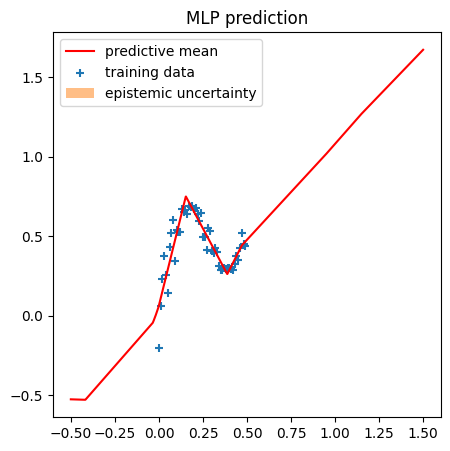

In [6]:
model = MLP(input_size=1, num_hidden_layers=2, layer_width=16)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()


for e in range(10001):

    optimizer.zero_grad()

    y_pred = model(x)

    loss = criterion(y_pred, y)
    
    if e%2000==0:
        print(f'epoch: {e}, loss: {loss.item():.4f}')


    loss.backward()

    optimizer.step()


plot_predictions(model,f'MLP prediction')


epoch: 0, loss: 0.9581
epoch: 2000, loss: 0.0820
epoch: 4000, loss: 0.0805
epoch: 6000, loss: 0.0781
epoch: 8000, loss: 0.0770
epoch: 10000, loss: 0.0738


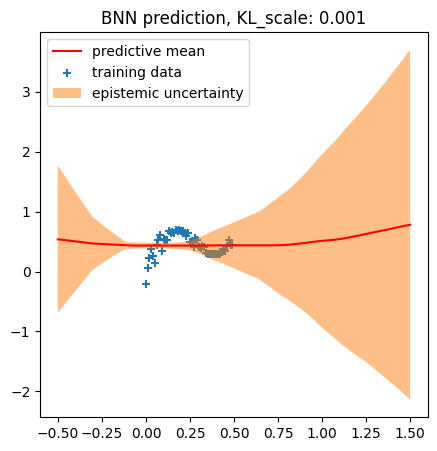

In [7]:
model = BayesianNN(input_size=1, output_size=1, num_hidden_layers=2, layer_width=16)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

kl_scale = 1e-3


for e in range(10001):

    optimizer.zero_grad()

    y_pred = model(x)

    #KL term encourages q to be more spread out (i.e. more stochasticity in the weights).
    loss = criterion(y_pred, y) + kl_scale * model.compute_total_kl_loss()
    
    if e%2000==0:
        print(f'epoch: {e}, loss: {loss.item():.4f}')


    loss.backward()

    optimizer.step()

 
plot_predictions(model,f'BNN prediction, KL_scale: {kl_scale}')

epoch: 0, loss: 1.2085
epoch: 2000, loss: 0.0265
epoch: 4000, loss: 0.0179
epoch: 6000, loss: 0.0164
epoch: 8000, loss: 0.0164
epoch: 10000, loss: 0.0176


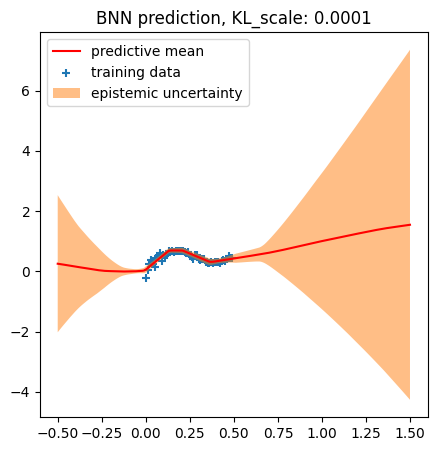

In [9]:
model = BayesianNN(input_size=1, output_size=1, num_hidden_layers=2, layer_width=16)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

kl_scale = 1e-4


for e in range(10001):

    optimizer.zero_grad()

    y_pred = model(x)

    #KL term encourages q to be more spread out (i.e. more stochasticity in the weights).
    loss = criterion(y_pred, y) + kl_scale * model.compute_total_kl_loss()
    
    if e%2000==0:
        print(f'epoch: {e}, loss: {loss.item():.4f}')


    loss.backward()

    optimizer.step()

 
plot_predictions(model,f'BNN prediction, KL_scale: {kl_scale}')

epoch: 0, loss: 1.8225
epoch: 2000, loss: 0.0074
epoch: 4000, loss: 0.0056
epoch: 6000, loss: 0.0042
epoch: 8000, loss: 0.0039
epoch: 10000, loss: 0.0050


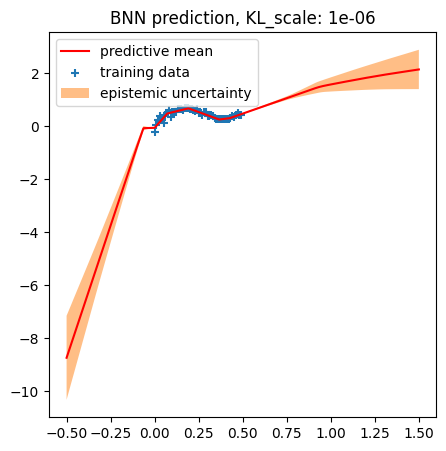

In [10]:
model = BayesianNN(input_size=1, output_size=1, num_hidden_layers=2, layer_width=16)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

kl_scale = 1e-6


for e in range(10001):

    optimizer.zero_grad()

    y_pred = model(x)

    #KL term encourages q to be more spread out (i.e. more stochasticity in the weights).
    loss = criterion(y_pred, y) + kl_scale * model.compute_total_kl_loss()
    
    if e%2000==0:
        print(f'epoch: {e}, loss: {loss.item():.4f}')


    loss.backward()

    optimizer.step()

 
plot_predictions(model,f'BNN prediction, KL_scale: {kl_scale}')

epoch: 0, loss: 0.0448
epoch: 2000, loss: 0.0040
epoch: 4000, loss: 0.0034
epoch: 6000, loss: 0.0025
epoch: 8000, loss: 0.0019
epoch: 10000, loss: 0.0015


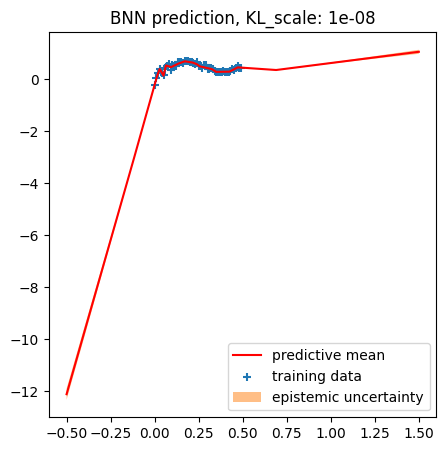

In [11]:
model = BayesianNN(input_size=1, output_size=1, num_hidden_layers=2, layer_width=16)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

kl_scale = 1e-8


for e in range(10001):

    optimizer.zero_grad()

    y_pred = model(x)

    #KL term encourages q to be more spread out (i.e. more stochasticity in the weights).
    loss = criterion(y_pred, y) + kl_scale * model.compute_total_kl_loss()
    
    if e%2000==0:
        print(f'epoch: {e}, loss: {loss.item():.4f}')


    loss.backward()

    optimizer.step()

 
plot_predictions(model,f'BNN prediction, KL_scale: {kl_scale}')